# New Notebook

Whats this notebook about?

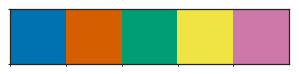

In [1]:
import sys
import os
from glob import glob
import re
import regex

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from g4netx import g4netx

from Bio.SeqIO import parse

## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [2]:
# this sequence can form quite a few different quadruplexes
seq = 'GGGGAAGGGTTGGGCCGGGATGGGCTGGG'

In [3]:
def groupspans(match):
    return [match.span(i) for i in range(1, 5)]

# re only finds one here because it consumes the string as it searches
g4_pattern = r'(GGG)[ACGT]{1,7}?(GGG)[ACGT]{1,7}?(GGG)[ACGT]{1,7}?(GGG)'
for m in re.finditer(g4_pattern, seq):
    print(m.group(0))
    print(groupspans(m))

GGGGAAGGGTTGGGCCGGG
[(0, 3), (6, 9), (11, 14), (16, 19)]


In [4]:
# if we use the newer regex module with non-overlapping regexes,
# we can get more, but still only one per position:
for m in regex.finditer(g4_pattern, seq, overlapped=True):
    print(m.group(0))
    print(groupspans(m))

GGGGAAGGGTTGGGCCGGG
[(0, 3), (6, 9), (11, 14), (16, 19)]
GGGAAGGGTTGGGCCGGG
[(1, 4), (6, 9), (11, 14), (16, 19)]
GGGTTGGGCCGGGATGGG
[(6, 9), (11, 14), (16, 19), (21, 24)]
GGGCCGGGATGGGCTGGG
[(11, 14), (16, 19), (21, 24), (26, 29)]


In [11]:
# g4netx uses network analysis to find all possible g4s
for m, strand in sorted(g4netx(seq, run_length=3), key=lambda x: [i[0] for i in x[0]]):
    print(seq[m[0][0]:m[-1][1]])
    print(m)

GGGGAAGGGTTGGGCCGGG
[(0, 3), (6, 9), (11, 14), (16, 19)]
GGGGAAGGGTTGGGCCGGGATGGG
[(0, 3), (6, 9), (11, 14), (21, 24)]
GGGGAAGGGTTGGGCCGGGATGGG
[(0, 3), (6, 9), (16, 19), (21, 24)]
GGGGAAGGGTTGGGCCGGGATGGGCTGGG
[(0, 3), (6, 9), (16, 19), (26, 29)]
GGGAAGGGTTGGGCCGGG
[(1, 4), (6, 9), (11, 14), (16, 19)]
GGGAAGGGTTGGGCCGGGATGGG
[(1, 4), (6, 9), (11, 14), (21, 24)]
GGGAAGGGTTGGGCCGGGATGGG
[(1, 4), (6, 9), (16, 19), (21, 24)]
GGGAAGGGTTGGGCCGGGATGGGCTGGG
[(1, 4), (6, 9), (16, 19), (26, 29)]
GGGAAGGGTTGGGCCGGGATGGG
[(1, 4), (11, 14), (16, 19), (21, 24)]
GGGAAGGGTTGGGCCGGGATGGGCTGGG
[(1, 4), (11, 14), (16, 19), (26, 29)]
GGGAAGGGTTGGGCCGGGATGGGCTGGG
[(1, 4), (11, 14), (21, 24), (26, 29)]
GGGTTGGGCCGGGATGGG
[(6, 9), (11, 14), (16, 19), (21, 24)]
GGGTTGGGCCGGGATGGGCTGGG
[(6, 9), (11, 14), (16, 19), (26, 29)]
GGGTTGGGCCGGGATGGGCTGGG
[(6, 9), (11, 14), (21, 24), (26, 29)]
GGGTTGGGCCGGGATGGGCTGGG
[(6, 9), (16, 19), (21, 24), (26, 29)]
GGGCCGGGATGGGCTGGG
[(11, 14), (16, 19), (21, 24), (26, 29)]


In [7]:
%%timeit -n 1 -r 3
with open('/home/matthew/Documents/genomes/tair10/fasta/tair10_genome.fa') as f:
    pg4_count = 0
    for record in parse(f, 'fasta'):
        for pg4 in g4netx(str(record.seq), run_length=3):
            pg4_count += 1

13079
13079
13079
8.34 s ± 7.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [79]:
BULGED_REGEX = create_bulged_regex(4, 5)

seq = 'GGGGAG'

[any(x.groups()) for x in re.finditer(BULGED_REGEX, seq)]

[False, True]

In [ ]:
[x.group(0) for x in re.finditer(
    '(?=G([ACT]{1,5})?G((?(1)|[]', seq)]

In [64]:
print(BULGED_REGEX)

(?=G([ACT]{1,5})?G((?(1)|[ACT]{1,5}))?G)


In [80]:
import regex

In [89]:
def create_bulged_regex(base, g_run_length, max_bulge_length):
    if base == 'G':
        bulge = '[ACT]{1,' + str(max_bulge_length) + '}'
    else:
        bulge = '[AGT]{1,' + str(max_bulge_length) + '}'
    regex = base
    bulge_backrefs = []
    for i in range(1, g_run_length):
        regex += '('
        for j in bulge_backrefs:
            regex += '(?(' + str(j) + ')|'
        regex += bulge
        regex += ')' * len(bulge_backrefs)
        regex += ')?'
        bulge_backrefs.append(i)
        regex += base
    return regex


In [94]:
BULGED_REGEX = create_bulged_regex('G', 3, 5)

seq = 'ATTTGTTTGGGGTTT'

[x.span() for x in regex.finditer(BULGED_REGEX, seq, overlapped=True)]

[(4, 10), (8, 11), (9, 12)]